# 02_hsn_v1_lean-voc2012

In [1]:
import time
import skimage.io as imgio
import pandas as pd
import numpy.matlib

from adp_cues import ADPCues
from utilities import *
from dataset import Dataset

MODEL_CNN_ROOT = '../database/models_cnn'
MODEL_WSSS_ROOT = '../database/models_wsss'

Using TensorFlow backend.


In [2]:
dataset = 'VOC2012'
model_type = 'VGG16'
batch_size = 16
sess_id = dataset + '_' + model_type
if model_type in ['VGG16', 'VGG16bg']:
    size = 321
else:
    size = 224
should_saveimg = False
is_verbose = True

if model_type in ['VGG16', 'VGG16bg']:
    img_size = 321
else:
    img_size = 224
sess_id = dataset + '_' + model_type
model_dir = os.path.join(MODEL_CNN_ROOT, sess_id)

if is_verbose:
    print('Predict: dataset=' + dataset + ', model=' + model_type)

database_dir = os.path.join(os.path.dirname(os.getcwd()), 'database')
if dataset == 'VOC2012':
    devkit_dir = os.path.join(database_dir, 'VOCdevkit', 'VOC2012')
    fgbg_modes = ['fg', 'bg']
    OVERLAY_R = 0.75
elif 'DeepGlobe' in dataset:
    devkit_dir = os.path.join(database_dir, 'DGdevkit')
    fgbg_modes = ['fg']
    OVERLAY_R = 0.25
img_dir = os.path.join(devkit_dir, 'JPEGImages')
gt_dir = os.path.join(devkit_dir, 'SegmentationClassAug')

out_dir = os.path.join('./out', sess_id)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
eval_dir = os.path.join('./eval', sess_id)
if not os.path.exists(eval_dir):
    os.makedirs(eval_dir)

Predict: dataset=VOC2012, model=VGG16


## Load network and data

In [3]:
# Load network and thresholds
mdl = {}
thresholds = {}
alpha = {}
final_layer = {}
for fgbg_mode in fgbg_modes:
    mdl[fgbg_mode] = build_model(model_dir, sess_id)
    thresholds[fgbg_mode] = load_thresholds(model_dir, sess_id)
    thresholds[fgbg_mode] = np.maximum(np.minimum(thresholds[fgbg_mode], 0), 1 / 3)
    alpha[fgbg_mode], final_layer[fgbg_mode] = get_grad_cam_weights(mdl[fgbg_mode],
                                                                    np.zeros((1, img_size, img_size, 3)))

# Load data and classes
ds = Dataset(data_type=dataset, size=img_size, batch_size=batch_size)
class_names, seg_class_names = load_classes(dataset)
colours = get_colours(dataset)
if 'DeepGlobe' in dataset:
    colours = colours[:-1]
gen_curr = ds.set_gens[ds.sets[ds.is_evals.index(True)]]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Found 1449 validated image filenames.


## Generate segmentations for single batch

In [4]:
# Process images in batches
intersects = np.zeros((len(colours)))
unions = np.zeros((len(colours)))
confusion_matrix = np.zeros((len(colours), len(colours)))
gt_count = np.zeros((len(colours)))
n_batches = 1
for iter_batch in range(n_batches):
    batch_start_time = time.time()
    if is_verbose:
        print('\tBatch #%d of %d' % (iter_batch + 1, n_batches))
    start_idx = iter_batch * batch_size
    end_idx = min(start_idx + batch_size - 1, len(gen_curr.filenames) - 1)
    cur_batch_sz = end_idx - start_idx + 1

    # Image reading
    start_time = time.time()
    img_batch_norm, img_batch = read_batch(gen_curr.directory, gen_curr.filenames[start_idx:end_idx + 1],
                                           cur_batch_sz, (img_size, img_size), dataset)
    if is_verbose:
        print('\t\tImage read time: %0.5f seconds (%0.5f seconds / image)' % (time.time() - start_time,
                                                                      (time.time() - start_time) / cur_batch_sz))

    # Generate patch confidence scores
    start_time = time.time()
    predicted_scores = {}
    is_pass_threshold = {}
    for fgbg_mode in fgbg_modes:
        predicted_scores[fgbg_mode] = mdl[fgbg_mode].predict(img_batch_norm)
        is_pass_threshold[fgbg_mode] = np.greater_equal(predicted_scores[fgbg_mode], thresholds[fgbg_mode])
    if is_verbose:
        print('\t\tGenerating patch confidence scores time: %0.5f seconds (%0.5f seconds / image)' %
                                            (time.time() - start_time, (time.time() - start_time) / cur_batch_sz))

    # Generate Grad-CAM
    start_time = time.time()
    H = {}
    for fgbg_mode in fgbg_modes:
        H[fgbg_mode] = grad_cam(mdl[fgbg_mode], alpha[fgbg_mode], img_batch_norm, is_pass_threshold[fgbg_mode],
                                final_layer[fgbg_mode], predicted_scores[fgbg_mode], orig_sz=[img_size, img_size],
                                should_upsample=True)
        H[fgbg_mode] = np.transpose(H[fgbg_mode], (0, 3, 1, 2))
    if is_verbose:
        print('\t\tGenerating Grad-CAM time: %0.5f seconds (%0.5f seconds / image)' % (time.time() - start_time,
                                                                (time.time() - start_time) / cur_batch_sz))

    # Modify fg Grad-CAM with bg activation
    start_time = time.time()
    if dataset == 'VOC2012':
        Y_gradcam = np.zeros((cur_batch_sz, len(seg_class_names), img_size, img_size))
        mode = 'mult'
        if mode == 'mult':
            X_bg = np.sum(H['bg'], axis=1)
            Y_gradcam[:, 0] = 0.15 * scipy.special.expit(np.max(X_bg) - X_bg)
        Y_gradcam[:, 1:] = H['fg']
    elif 'DeepGlobe' in dataset:
        Y_gradcam = H['fg'][:, :-1, :, :]
    if is_verbose:
        print('\t\tFg/Bg modifications time: %0.5f seconds (%0.5f seconds / image)' % (time.time() - start_time,
                                                                     (time.time() - start_time) / cur_batch_sz))

    # FC-CRF
    start_time = time.time()
    if dataset == 'VOC2012':
        dcrf_config = np.array([3 / 4, 3, 80 / 4, 13, 10, 10])  # test (since 2448 / 500 = 4.896 ~= 4)
    elif 'DeepGlobe' in dataset:
        dcrf_config = np.array([3, 3, 80, 13, 10, 10])  # test
    Y_crf = dcrf_process(Y_gradcam, img_batch, dcrf_config)
    if is_verbose:
        print('\t\tCRF time: %0.5f seconds (%0.5f seconds / image)' % (time.time() - start_time,
                                                                 (time.time() - start_time) / cur_batch_sz))
    elapsed_time = time.time() - batch_start_time
    if is_verbose:
        print('\t\tElapsed time: %0.5f seconds (%0.5f seconds / image)' % (elapsed_time, elapsed_time / cur_batch_sz))

    if dataset == 'VOC2012':
        for iter_file, filename in enumerate(gen_curr.filenames[start_idx:end_idx + 1]):
            # Load GT segmentation
            gt_filepath = os.path.join(gt_dir, filename.replace('.jpg', '.png'))
            gt_idx = cv2.cvtColor(cv2.imread(gt_filepath), cv2.COLOR_BGR2RGB)[:, :, 0]
            # Load predicted segmentation
            pred_idx = cv2.resize(np.uint8(Y_crf[iter_file]), (gt_idx.shape[1], gt_idx.shape[0]),
                                  interpolation=cv2.INTER_NEAREST)
            pred_segmask = np.zeros((gt_idx.shape[0], gt_idx.shape[1], 3))
            # Evaluate predicted segmentation
            for k in range(len(colours)):
                intersects[k] += np.sum((gt_idx == k) & (pred_idx == k))
                unions[k] += np.sum((gt_idx == k) | (pred_idx == k))
                confusion_matrix[k, :] += np.bincount(pred_idx[gt_idx == k], minlength=len(colours))
                pred_segmask += np.expand_dims(pred_idx == k, axis=2) * \
                                np.expand_dims(np.expand_dims(colours[k], axis=0), axis=0)
                gt_count[k] += np.sum(gt_idx == k)
            # Save outputted segmentation to file
            if should_saveimg:
                orig_filepath = os.path.join(img_dir, filename)
                orig_img = cv2.cvtColor(cv2.imread(orig_filepath), cv2.COLOR_BGR2RGB)
                imgio.imsave(os.path.join(out_dir, filename.replace('.jpg', '') + '.png'), pred_segmask / 256.0)
                imgio.imsave(os.path.join(out_dir, filename.replace('.jpg', '') + '_overlay.png'),
                             (1 - OVERLAY_R) * orig_img / 256.0 +
                             OVERLAY_R * pred_segmask / 256.0)
    elif 'DeepGlobe' in dataset:
        for iter_file, filename in enumerate(gen_curr.filenames[start_idx:end_idx + 1]):
            # Load GT segmentation
            gt_filepath = os.path.join(gt_dir, filename.replace('.jpg', '.png'))
            gt_curr = cv2.cvtColor(cv2.imread(gt_filepath), cv2.COLOR_BGR2RGB)
            gt_r = gt_curr[:, :, 0]
            gt_g = gt_curr[:, :, 1]
            gt_b = gt_curr[:, :, 2]
            # Load predicted segmentation
            pred_idx = cv2.resize(np.uint8(Y_crf[iter_file]), (gt_curr.shape[1], gt_curr.shape[0]),
                                  interpolation=cv2.INTER_NEAREST)
            pred_segmask = np.zeros((gt_curr.shape[0], gt_curr.shape[1], 3))
            # Evaluate predicted segmentation
            for k, gt_colour in enumerate(colours):
                gt_mask = (gt_r == gt_colour[0]) & (gt_g == gt_colour[1]) & (gt_b == gt_colour[2])
                pred_mask = pred_idx == k
                intersects[k] += np.sum(gt_mask & pred_mask)
                unions[k] += np.sum(gt_mask | pred_mask)
                confusion_matrix[k, :] += np.bincount(pred_idx[gt_mask], minlength=len(colours))
                pred_segmask += np.expand_dims(pred_mask, axis=2) * \
                                np.expand_dims(np.expand_dims(colours[k], axis=0), axis=0)
                gt_count[k] += np.sum(gt_mask)
            # Save outputted segmentation to file
            if should_saveimg:
                orig_filepath = os.path.join(img_dir, filename)
                orig_img = cv2.cvtColor(cv2.imread(orig_filepath), cv2.COLOR_BGR2RGB)
                orig_img = cv2.resize(orig_img, (orig_img.shape[0] // 4, orig_img.shape[1] // 4))
                pred_segmask = cv2.resize(pred_segmask, (pred_segmask.shape[0] // 4, pred_segmask.shape[1] // 4),
                                          interpolation=cv2.INTER_NEAREST)
                imgio.imsave(os.path.join(out_dir, filename.replace('.jpg', '') + '.png'), pred_segmask / 256.0)
                imgio.imsave(os.path.join(out_dir, filename.replace('.jpg', '') + '_overlay.png'),
                             (1 - OVERLAY_R) * orig_img / 256.0 + OVERLAY_R * pred_segmask / 256.0)

	Batch #1 of 1
		Image read time: 0.09221 seconds (0.00576 seconds / image)
		Generating patch confidence scores time: 49.51458 seconds (3.09466 seconds / image)
		Generating Grad-CAM time: 51.20006 seconds (3.20000 seconds / image)
		Fg/Bg modifications time: 0.37858 seconds (0.02366 seconds / image)
		CRF time: 5.80165 seconds (0.36260 seconds / image)
		Elapsed time: 106.98709 seconds (6.68669 seconds / image)


## Show sample segmentations

In [5]:
img_filepath = os.path.join(gen_curr.directory, gen_curr.filenames[0])
I = cv2.cvtColor(cv2.imread(img_filepath), cv2.COLOR_BGR2RGB)
gt_filepath = os.path.join(gt_dir, gen_curr.filenames[0].replace('.jpg', '.png'))
gt_idx = np.expand_dims(cv2.cvtColor(cv2.imread(gt_filepath), cv2.COLOR_BGR2RGB)[:, :, 0], axis=0)
G = maxconf_class_as_colour(gt_idx, colours, gt_idx.shape[1:3])

Text(0.5, 1.0, 'Ground truth\n segmentation')

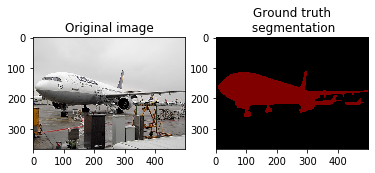

In [6]:
plt.figure
plt.subplot(121)
plt.imshow(I.astype('uint8'))
plt.title('Original image')
plt.subplot(122)
plt.imshow(G[0].astype('uint8'))
plt.title('Ground truth\n segmentation')

In [7]:
# Load predicted segmentation
pred_idx = cv2.resize(np.uint8(Y_crf[0]), (gt_idx.shape[2], gt_idx.shape[1]), interpolation=cv2.INTER_NEAREST)
Y = np.zeros((gt_idx.shape[1], gt_idx.shape[2], 3))
# Evaluate predicted segmentation
for k in range(len(colours)):
    Y += np.expand_dims(pred_idx == k, axis=2) * np.expand_dims(np.expand_dims(colours[k], axis=0), axis=0)
# Obtain overlay
Y_overlay = (1 - OVERLAY_R) * I.astype('uint8') + OVERLAY_R * Y

Text(0.5, 1.0, 'Overlaid\n Segmentation')

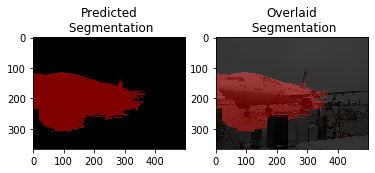

In [8]:
plt.figure
plt.subplot(121)
plt.imshow(Y.astype('uint8'))
plt.title('Predicted\n Segmentation')
plt.subplot(122)
plt.imshow(Y_overlay.astype('uint8'))
plt.title('Overlaid\n Segmentation')